In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
import shap


In [2]:
df = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn copy.csv")
df.head()
df.info()
df['Churn'].value_counts()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


Churn
No     5174
Yes    1869
Name: count, dtype: int64

In [3]:
df.drop(['customerID'], axis=1, inplace=True)
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
num_cols = df.select_dtypes(include=['float64', 'int64']).columns
df[num_cols] = df[num_cols].fillna(df[num_cols].median())



In [7]:
# Remove any extra spaces or invisible characters from column names
df.columns = df.columns.str.strip()

# Now drop the ID column safely
df.drop('customerID', axis=1, inplace=True)


KeyError: "['customerID'] not found in axis"

In [ ]:
df.columns.tolist()


In [10]:
 # ✅ 1. Convert 'TotalCharges' to numeric (some values may be blank)
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# ✅ 2. Fill missing numeric values with median
num_cols = df.select_dtypes(include=['float64', 'int64']).columns
df[num_cols] = df[num_cols].fillna(df[num_cols].median())

# ✅ 3. Quick check to ensure no missing values remain
print(df.isnull().sum())


gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64


In [12]:
le = LabelEncoder()
for col in df.select_dtypes(include='object').columns:
    df[col] = le.fit_transform(df[col])


In [14]:
X = df.drop('Churn', axis=1)
y = df['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [16]:
sm = SMOTE(random_state=42)
X_train, y_train = sm.fit_resample(X_train, y_train)


In [18]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [20]:
model = XGBClassifier(random_state=42)
model.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

              precision    recall  f1-score   support

           0       0.85      0.85      0.85      1036
           1       0.57      0.58      0.57       373

    accuracy                           0.77      1409
   macro avg       0.71      0.71      0.71      1409
weighted avg       0.77      0.77      0.77      1409

ROC-AUC: 0.7109836761311292


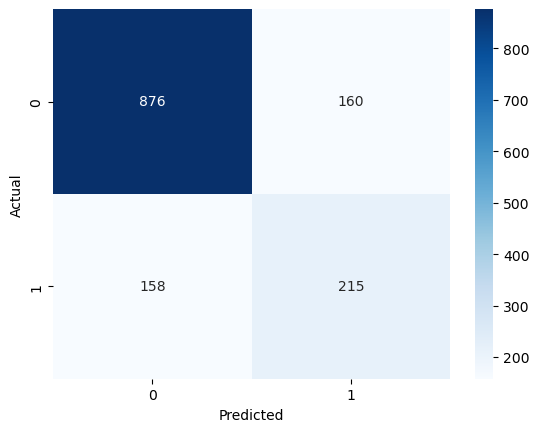

In [22]:
y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_pred))

sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


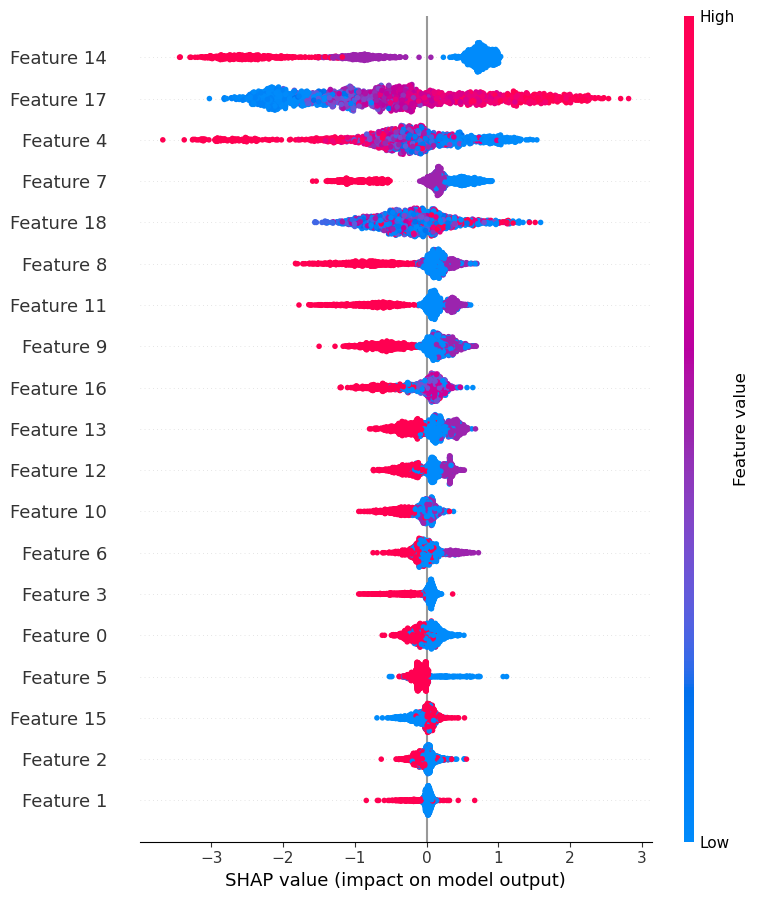

In [24]:
explainer = shap.Explainer(model)
shap_values = explainer(X_test)

shap.summary_plot(shap_values, X_test)


Dataset Shape: (7043, 21)
Columns: ['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn']


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes



Missing values after cleaning:
 customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.86      0.86      1036
           1       0.60      0.57      0.59       373

    accuracy                           0.79      1409
   macro avg       0.73      0.72      0.72      1409
weighted avg       0.78      0.79      0.78      1409

ROC-AUC Score: 0.7174725951535604


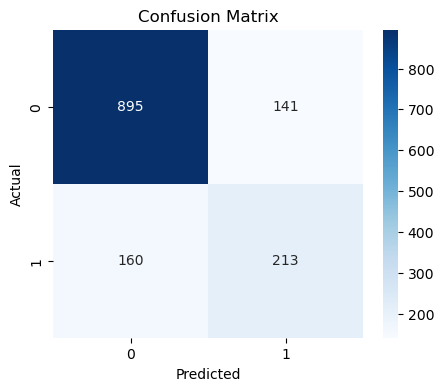

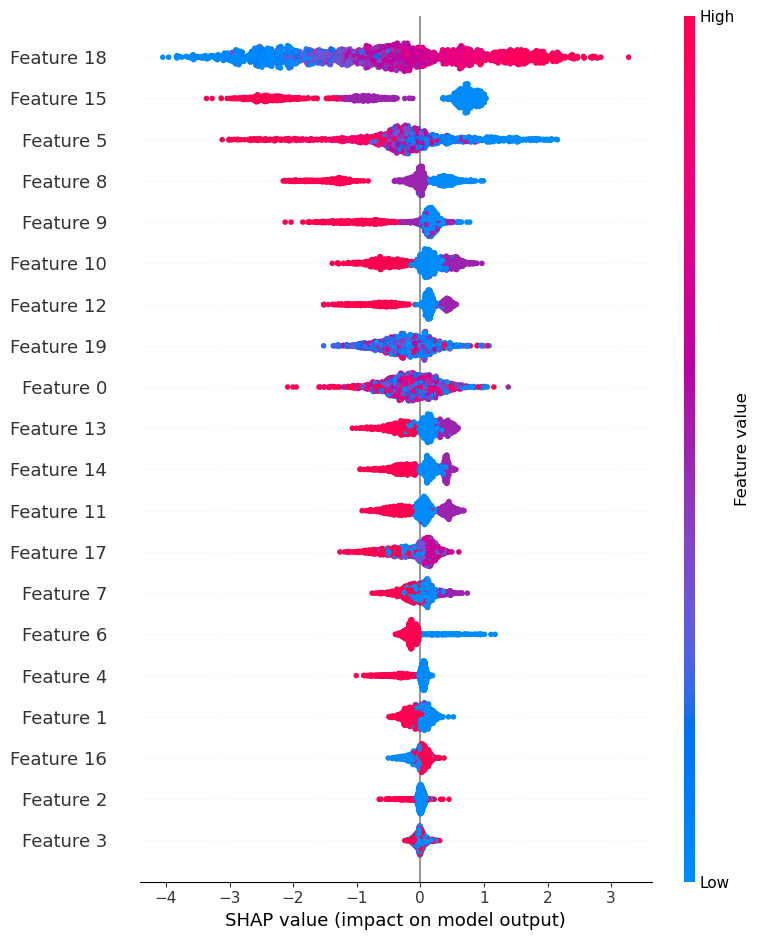


✅ Project Completed Successfully!
- Model trained using XGBoost with SMOTE-balanced data.
- Evaluated with classification metrics and ROC-AUC.
- SHAP used to interpret key churn drivers (e.g., Contract, Tenure, MonthlyCharges).



In [26]:
# 🧠 CUSTOMER CHURN PREDICTION — FULL PIPELINE
# Author: Poojitha Alla
# Environment: Anaconda (MacBook), Jupyter Notebook

# ================================================================
# 1️⃣ IMPORT LIBRARIES
# ================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
import shap

# ================================================================
# 2️⃣ LOAD DATA
# ================================================================
df = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn copy.csv")

# View basic info
print("Dataset Shape:", df.shape)
print("Columns:", df.columns.tolist())
display(df.head())

# ================================================================
# 3️⃣ CLEAN & PREPROCESS DATA
# ================================================================

# Convert TotalCharges to numeric (some values might be blank)
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Fill missing numeric values with median
num_cols = df.select_dtypes(include=['float64', 'int64']).columns
df[num_cols] = df[num_cols].fillna(df[num_cols].median())

# Check for remaining nulls
print("\nMissing values after cleaning:\n", df.isnull().sum())

# ================================================================
# 4️⃣ ENCODE CATEGORICAL VARIABLES
# ================================================================
le = LabelEncoder()
for col in df.select_dtypes(include='object').columns:
    df[col] = le.fit_transform(df[col])

# ================================================================
# 5️⃣ SPLIT DATA
# ================================================================
X = df.drop('Churn', axis=1)
y = df['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ================================================================
# 6️⃣ HANDLE CLASS IMBALANCE
# ================================================================
sm = SMOTE(random_state=42)
X_train, y_train = sm.fit_resample(X_train, y_train)

# ================================================================
# 7️⃣ SCALE FEATURES
# ================================================================
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# ================================================================
# 8️⃣ TRAIN MODEL (XGBOOST)
# ================================================================
model = XGBClassifier(random_state=42)
model.fit(X_train, y_train)

# ================================================================
# 9️⃣ EVALUATE MODEL
# ================================================================
y_pred = model.predict(X_test)

print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, y_pred))

# Confusion Matrix
plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# ================================================================
# 🔟 FEATURE IMPORTANCE (SHAP)
# ================================================================
explainer = shap.Explainer(model)
shap_values = explainer(X_test)

# Summary plot for top feature influences
shap.summary_plot(shap_values, X_test, show=True)

# ================================================================
# 🧾 11️⃣ CONCLUSION
# ================================================================
print("""
✅ Project Completed Successfully!
- Model trained using XGBoost with SMOTE-balanced data.
- Evaluated with classification metrics and ROC-AUC.
- SHAP used to interpret key churn drivers (e.g., Contract, Tenure, MonthlyCharges).
""")


In [27]:
pip install streamlit_jupyter


Note: you may need to restart the kernel to use updated packages.


In [ ]:
Writing churn_app.py


In [ ]:
streamlit run churn_app.py



In [ ]:
cd ~/Customer_Churn_Project
streamlit run churn_app.py


In [ ]:
%%writefile churn_app.py
import streamlit as st

st.title("🧠 Customer Churn Prediction")
st.write("This is a demo Streamlit app running from Jupyter Notebook!")


In [ ]:
!streamlit run churn_app.py


In [ ]:
%%writefile churn_app.py
# ======================================================
# 📉 CUSTOMER CHURN PREDICTION — Streamlit App
# Author: Poojitha Alla
# ======================================================
import streamlit as st
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE

# ------- Page setup -------
st.set_page_config(page_title="Customer Churn Prediction", layout="wide")
st.title("📉 Customer Churn Prediction")
st.caption("End-to-end demo: clean → train → predict. If anything goes wrong, the error will appear below (no blank page).")

# Helpful sidebar
with st.sidebar:
    st.header("Quick Actions")
    st.markdown("1) Place **Telco-Customer-Churn.csv** next to this app file.\n"
                "2) Or upload a CSV below.\n"
                "3) Use the *Manual Test* form to try one sample.")
    st.info("Tip: If you see nothing here, your app didn’t run. Check the terminal for errors.")

# ------- Utility: show errors in the UI instead of going blank -------
def show_exception(e, where=""):
    st.error(f"⚠️ Error {('in ' + where) if where else ''}: {type(e).__name__}: {e}")

# ------- Data Loader -------
@st.cache_data
def load_telco_from_disk(path="Telco-Customer-Churn.csv"):
    df = pd.read_csv(path)
    return df

def clean_and_encode(df: pd.DataFrame):
    # Convert TotalCharges and fill numeric NaNs
    if "TotalCharges" in df.columns:
        df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")
    num_cols = df.select_dtypes(include=[np.number]).columns
    df[num_cols] = df[num_cols].fillna(df[num_cols].median())

    # Encode categoricals
    le = LabelEncoder()
    for col in df.select_dtypes(include="object").columns:
        df[col] = df[col].astype(str)  # ensure strings
        df[col] = le.fit_transform(df[col])
    return df

# ------- Model trainer -------
@st.cache_resource
def train_model_from_df(df: pd.DataFrame):
    if "Churn" not in df.columns:
        raise ValueError("The dataset must contain a 'Churn' column (target).")

    X = df.drop("Churn", axis=1)
    y = df["Churn"]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y if len(np.unique(y))>1 else None
    )

    # Balance classes
    sm = SMOTE(random_state=42)
    X_train, y_train = sm.fit_resample(X_train, y_train)

    # Scale
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test  = scaler.transform(X_test)

    # Model
    model = XGBClassifier(random_state=42)
    model.fit(X_train, y_train)

    return model, scaler, X.columns.tolist(), (X_test, y_test)

# ------- Data source controls -------
st.subheader("📂 Data Source")
data_tab, upload_tab = st.tabs(["Use Local CSV", "Upload CSV"])

df = None
with data_tab:
    st.write("Looking for **Telco-Customer-Churn.csv** in the current folder.")
    if st.button("Load local CSV"):
        try:
            raw = load_telco_from_disk()
            st.success(f"Loaded local CSV with shape {raw.shape}.")
            st.dataframe(raw.head())
            df = clean_and_encode(raw.copy())
        except Exception as e:
            show_exception(e, "loading local CSV")

with upload_tab:
    up = st.file_uploader("Or upload a CSV", type=["csv"])
    if up is not None:
        try:
            raw = pd.read_csv(up)
            st.success(f"Uploaded CSV with shape {raw.shape}.")
            st.dataframe(raw.head())
            df = clean_and_encode(raw.copy())
        except Exception as e:
            show_exception(e, "reading uploaded CSV")

# If no data yet, show a gentle nudge but keep the page non-empty
if df is None:
    st.info("Load the Telco CSV (local or upload) to enable training and prediction.")
else:
    # ------- Train model -------
    st.subheader("🧠 Train Model")
    try:
        model, scaler, feature_names, test_pack = train_model_from_df(df)
        X_test, y_test = test_pack

        st.success("Model trained successfully.")
        # Quick metrics
        try:
            from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
            y_pred = model.predict(X_test)
            # Some models return labels; for ROC AUC you might need probabilities:
            y_proba = None
            try:
                y_proba = model.predict_proba(X_test)[:, 1]
            except Exception:
                pass

            col1, col2 = st.columns(2)
            with col1:
                st.write("**Classification Report**")
                st.text(classification_report(y_test, y_pred, zero_division=0))
            with col2:
                st.write("**Confusion Matrix**")
                cm = confusion_matrix(y_test, y_pred)
                fig, ax = plt.subplots()
                im = ax.imshow(cm, interpolation="nearest")
                ax.set_title("Confusion Matrix")
                ax.set_xlabel("Predicted")
                ax.set_ylabel("Actual")
                for i in range(cm.shape[0]):
                    for j in range(cm.shape[1]):
                        ax.text(j, i, cm[i, j], ha="center", va="center")
                st.pyplot(fig)

            if y_proba is not None:
                try:
                    auc = roc_auc_score(y_test, y_proba)
                    st.metric("ROC-AUC", f"{auc:.3f}")
                except Exception:
                    pass
        except Exception as e:
            show_exception(e, "evaluation")

        # ------- Batch predict on same schema -------
        st.subheader("🧾 Batch Prediction")
        pred_file = st.file_uploader("Upload a CSV with the same columns (except 'Churn' can be missing) to get predictions:", type=["csv"], key="pred_uploader")
        if pred_file is not None:
            try:
                newdf_raw = pd.read_csv(pred_file)
                st.write("Preview:", newdf_raw.head())
                newdf_proc = clean_and_encode(newdf_raw.copy())
                # Align columns (add missing, drop extras)
                for c in feature_names:
                    if c not in newdf_proc.columns:
                        newdf_proc[c] = 0
                newdf_proc = newdf_proc[feature_names]

                X_new = scaler.transform(newdf_proc.values)
                preds = model.predict(X_new)
                out = newdf_raw.copy()
                out["Predicted_Churn"] = preds
                st.success("Predictions generated.")
                st.dataframe(out.head())
                st.download_button("Download Predictions CSV", out.to_csv(index=False).encode("utf-8"), file_name="predictions.csv", mime="text/csv")
            except Exception as e:
                show_exception(e, "batch prediction")

        # ------- Manual single prediction -------
        st.subheader("🧮 Manual Test (minimal inputs)")
        with st.form("manual_form"):
            tenure = st.slider("Tenure (months)", 0, 72, 12)
            monthly_charges = st.number_input("Monthly Charges", 0.0, 200.0, 70.0, step=1.0)
            total_charges = st.number_input("Total Charges", 0.0, 10000.0, 1500.0, step=10.0)
            submitted = st.form_submit_button("Predict")
        if submitted:
            try:
                # Make a minimal feature row using any subset of known features
                row = {c: 0 for c in feature_names}
                for k, v in {
                    "tenure": tenure,
                    "MonthlyCharges": monthly_charges,
                    "TotalCharges": total_charges,
                }.items():
                    if k in row:
                        row[k] = v
                sample = pd.DataFrame([row])[feature_names]
                X_one = scaler.transform(sample.values)
                pred = model.predict(X_one)[0]
                st.success("Prediction: **Churn** 😞" if int(pred) == 1 else "Prediction: **No Churn** 😊")
            except Exception as e:
                show_exception(e, "manual prediction")
    except Exception as e:
        show_exception(e, "training")

st.divider()
st.caption("Built by Poojitha Alla — M.Sc. Data Science, Universität Trier")


In [ ]:
!streamlit run churn_app.py --server.port 8502
